# Bitcoin LSTM Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
bitcoin_df = pd.read_csv(bitcoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                      687.926
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_polarity', 'bitcoin_subjectivity', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

bitcoin_count                 1.557000e+03
bitcoin_polarity_zeros        1.050641e-01
bitcoin_subjectivity_zeros    3.030843e-01
closePriceUsd                 3.611949e+04
highPriceUsd                  3.613191e+04
lowPriceUsd                   3.544398e+04
volume                        6.226012e+10
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 7)
Target shape: (128, 1)


In [7]:
# extracting targets from the val_dataset to plot alongside predictions
y_val = np.concatenate([y for x, y in val_dataset], axis=0)

In [8]:
# This doesn't create a full dataset between the points
# find better method if time (like below)
combined_dataset = train_dataset.concatenate(val_dataset)

In [9]:
# setting up customised test_dataset
test_data = timeperiod_df[(training_samples+validation_samples) - lookback + delay:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+ delay + delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=lookback,
        sampling_rate=step,
        batch_size=batch_size,
    )

## LSTM models

Epoch 1/20
13/13 [==============================] - 12s 656ms/step - loss: 0.3898 - val_loss: 0.4830
Epoch 2/20
13/13 [==============================] - 7s 522ms/step - loss: 0.2167 - val_loss: 0.4415
Epoch 3/20
13/13 [==============================] - 6s 483ms/step - loss: 0.1654 - val_loss: 0.4742
Epoch 4/20
13/13 [==============================] - 7s 501ms/step - loss: 0.1669 - val_loss: 0.4488
Epoch 5/20
13/13 [==============================] - 7s 585ms/step - loss: 0.1628 - val_loss: 0.4158
Epoch 6/20
13/13 [==============================] - 7s 510ms/step - loss: 0.1584 - val_loss: 0.3833
Epoch 7/20
13/13 [==============================] - 7s 521ms/step - loss: 0.1539 - val_loss: 0.3514
Epoch 8/20
13/13 [==============================] - 6s 499ms/step - loss: 0.1470 - val_loss: 0.2842
Epoch 9/20
13/13 [==============================] - 8s 605ms/step - loss: 0.1350 - val_loss: 0.1952
Epoch 10/20
13/13 [==============================] - 8s 617ms/step - loss: 0.1248 - val_loss: 0.137

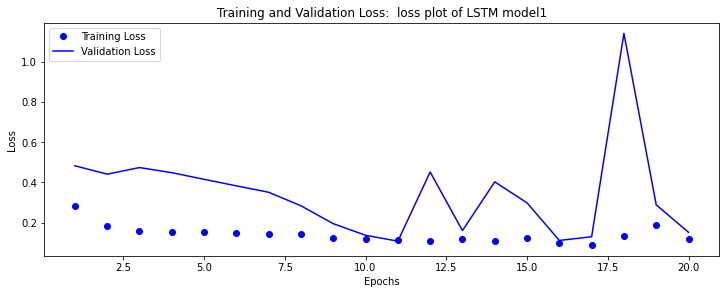

In [10]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(100))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

Epoch 1/20
13/13 [==============================] - 13s 711ms/step - loss: 0.4389 - val_loss: 0.5802
Epoch 2/20
13/13 [==============================] - 6s 491ms/step - loss: 0.2154 - val_loss: 0.5094
Epoch 3/20
13/13 [==============================] - 7s 558ms/step - loss: 0.1693 - val_loss: 0.5095
Epoch 4/20
13/13 [==============================] - 6s 498ms/step - loss: 0.1767 - val_loss: 0.4049
Epoch 5/20
13/13 [==============================] - 8s 619ms/step - loss: 0.1669 - val_loss: 0.3701
Epoch 6/20
13/13 [==============================] - 7s 548ms/step - loss: 0.1600 - val_loss: 0.3202
Epoch 7/20
13/13 [==============================] - 7s 512ms/step - loss: 0.1562 - val_loss: 0.3106
Epoch 8/20
13/13 [==============================] - 8s 643ms/step - loss: 0.1499 - val_loss: 0.2905
Epoch 9/20
13/13 [==============================] - 7s 565ms/step - loss: 0.1431 - val_loss: 0.2701
Epoch 10/20
13/13 [==============================] - 7s 587ms/step - loss: 0.1325 - val_loss: 0.211

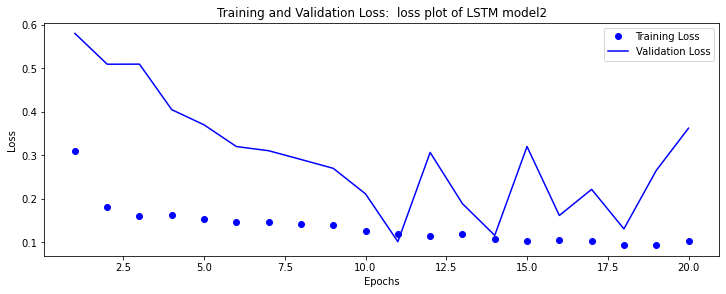

In [11]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(100))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")

Epoch 1/20
13/13 [==============================] - 10s 488ms/step - loss: 0.4095 - val_loss: 0.4524
Epoch 2/20
13/13 [==============================] - 5s 405ms/step - loss: 0.1922 - val_loss: 0.3874
Epoch 3/20
13/13 [==============================] - 5s 417ms/step - loss: 0.1574 - val_loss: 0.3988
Epoch 4/20
13/13 [==============================] - 6s 449ms/step - loss: 0.1568 - val_loss: 0.3703
Epoch 5/20
13/13 [==============================] - 5s 415ms/step - loss: 0.1547 - val_loss: 0.3352
Epoch 6/20
13/13 [==============================] - 7s 476ms/step - loss: 0.1514 - val_loss: 0.3063
Epoch 7/20
13/13 [==============================] - 5s 397ms/step - loss: 0.1481 - val_loss: 0.2842
Epoch 8/20
13/13 [==============================] - 5s 388ms/step - loss: 0.1441 - val_loss: 0.2676
Epoch 9/20
13/13 [==============================] - 5s 418ms/step - loss: 0.1398 - val_loss: 0.2594
Epoch 10/20
13/13 [==============================] - 5s 403ms/step - loss: 0.1344 - val_loss: 0.227

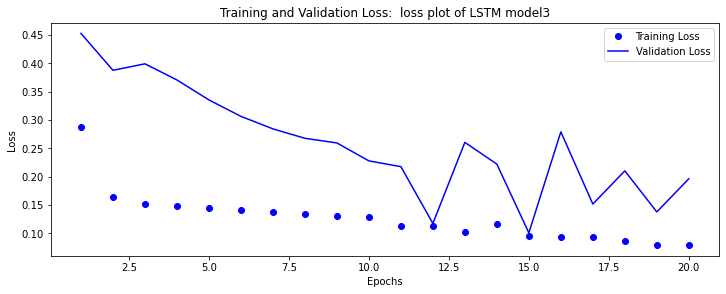

In [12]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(50))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")

Epoch 1/20
13/13 [==============================] - 10s 504ms/step - loss: 0.3196 - val_loss: 0.4858
Epoch 2/20
13/13 [==============================] - 6s 441ms/step - loss: 0.1923 - val_loss: 0.4208
Epoch 3/20
13/13 [==============================] - 5s 423ms/step - loss: 0.1713 - val_loss: 0.3689
Epoch 4/20
13/13 [==============================] - 7s 556ms/step - loss: 0.1634 - val_loss: 0.3440
Epoch 5/20
13/13 [==============================] - 5s 425ms/step - loss: 0.1627 - val_loss: 0.3181
Epoch 6/20
13/13 [==============================] - 6s 429ms/step - loss: 0.1557 - val_loss: 0.2730
Epoch 7/20
13/13 [==============================] - 7s 547ms/step - loss: 0.1499 - val_loss: 0.2729
Epoch 8/20
13/13 [==============================] - 8s 606ms/step - loss: 0.1479 - val_loss: 0.2542
Epoch 9/20
13/13 [==============================] - 5s 390ms/step - loss: 0.1378 - val_loss: 0.1817
Epoch 10/20
13/13 [==============================] - 7s 516ms/step - loss: 0.1253 - val_loss: 0.149

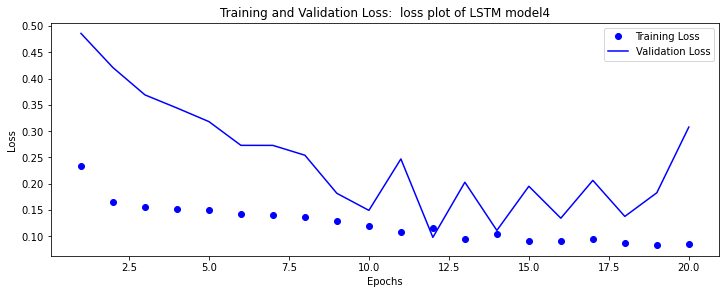

In [13]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(50))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")

Epoch 1/30
13/13 [==============================] - 8s 359ms/step - loss: 0.4035 - val_loss: 0.4754
Epoch 2/30
13/13 [==============================] - 5s 430ms/step - loss: 0.1835 - val_loss: 0.3790
Epoch 3/30
13/13 [==============================] - 4s 320ms/step - loss: 0.1668 - val_loss: 0.3356
Epoch 4/30
13/13 [==============================] - 4s 351ms/step - loss: 0.1605 - val_loss: 0.3047
Epoch 5/30
13/13 [==============================] - 4s 320ms/step - loss: 0.1549 - val_loss: 0.2828
Epoch 6/30
13/13 [==============================] - 4s 348ms/step - loss: 0.1495 - val_loss: 0.2684
Epoch 7/30
13/13 [==============================] - 4s 315ms/step - loss: 0.1441 - val_loss: 0.2594
Epoch 8/30
13/13 [==============================] - 4s 316ms/step - loss: 0.1374 - val_loss: 0.2366
Epoch 9/30
13/13 [==============================] - 4s 336ms/step - loss: 0.1276 - val_loss: 0.1593
Epoch 10/30
13/13 [==============================] - 4s 317ms/step - loss: 0.1168 - val_loss: 0.1295

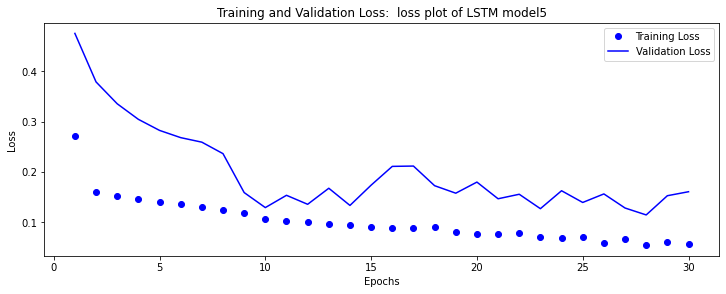

In [14]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(50, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(50))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")

Epoch 1/20
13/13 [==============================] - 8s 359ms/step - loss: 0.3516 - val_loss: 0.6387
Epoch 2/20
13/13 [==============================] - 5s 360ms/step - loss: 0.2005 - val_loss: 0.4381
Epoch 3/20
13/13 [==============================] - 5s 372ms/step - loss: 0.1741 - val_loss: 0.3796
Epoch 4/20
13/13 [==============================] - 5s 387ms/step - loss: 0.1616 - val_loss: 0.3387
Epoch 5/20
13/13 [==============================] - 4s 347ms/step - loss: 0.1542 - val_loss: 0.3144
Epoch 6/20
13/13 [==============================] - 5s 372ms/step - loss: 0.1500 - val_loss: 0.2777
Epoch 7/20
13/13 [==============================] - 5s 385ms/step - loss: 0.1470 - val_loss: 0.2708
Epoch 8/20
13/13 [==============================] - 5s 373ms/step - loss: 0.1452 - val_loss: 0.2453
Epoch 9/20
13/13 [==============================] - 4s 308ms/step - loss: 0.1399 - val_loss: 0.2342
Epoch 10/20
13/13 [==============================] - 4s 315ms/step - loss: 0.1380 - val_loss: 0.2102

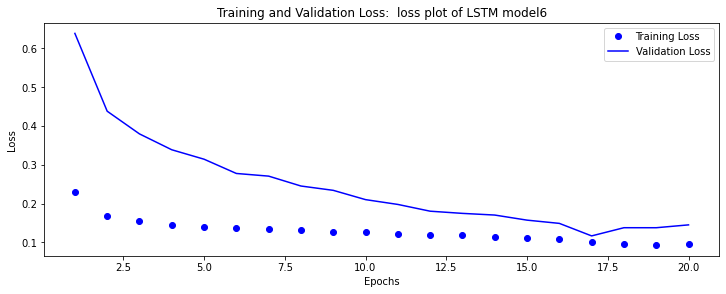

In [15]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(50))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")

Epoch 1/30
13/13 [==============================] - 8s 412ms/step - loss: 0.2313 - val_loss: 0.3768
Epoch 2/30
13/13 [==============================] - 3s 244ms/step - loss: 0.1590 - val_loss: 0.2879
Epoch 3/30
13/13 [==============================] - 3s 248ms/step - loss: 0.1456 - val_loss: 0.2618
Epoch 4/30
13/13 [==============================] - 3s 252ms/step - loss: 0.1416 - val_loss: 0.2447
Epoch 5/30
13/13 [==============================] - 3s 239ms/step - loss: 0.1385 - val_loss: 0.2308
Epoch 6/30
13/13 [==============================] - 3s 240ms/step - loss: 0.1356 - val_loss: 0.2186
Epoch 7/30
13/13 [==============================] - 3s 249ms/step - loss: 0.1325 - val_loss: 0.2070
Epoch 8/30
13/13 [==============================] - 3s 251ms/step - loss: 0.1294 - val_loss: 0.1954
Epoch 9/30
13/13 [==============================] - 3s 252ms/step - loss: 0.1260 - val_loss: 0.1831
Epoch 10/30
13/13 [==============================] - 4s 275ms/step - loss: 0.1225 - val_loss: 0.1702

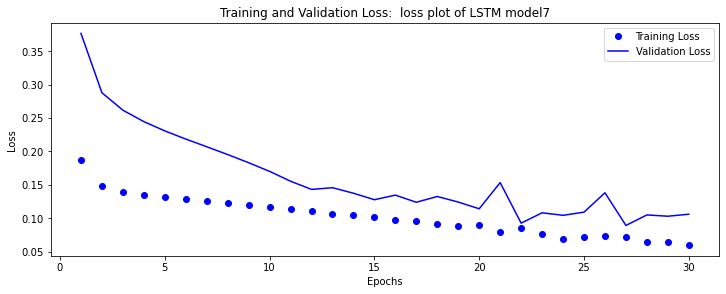

In [16]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(32))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")

Epoch 1/20
13/13 [==============================] - 9s 395ms/step - loss: 0.3983 - val_loss: 0.3388
Epoch 2/20
13/13 [==============================] - 4s 332ms/step - loss: 0.1733 - val_loss: 0.2905
Epoch 3/20
13/13 [==============================] - 4s 301ms/step - loss: 0.1621 - val_loss: 0.2632
Epoch 4/20
13/13 [==============================] - 3s 262ms/step - loss: 0.1551 - val_loss: 0.2593
Epoch 5/20
13/13 [==============================] - 3s 268ms/step - loss: 0.1513 - val_loss: 0.2518
Epoch 6/20
13/13 [==============================] - 4s 304ms/step - loss: 0.1479 - val_loss: 0.2447
Epoch 7/20
13/13 [==============================] - 4s 280ms/step - loss: 0.1456 - val_loss: 0.2347
Epoch 8/20
13/13 [==============================] - 3s 258ms/step - loss: 0.1398 - val_loss: 0.2325
Epoch 9/20
13/13 [==============================] - 3s 270ms/step - loss: 0.1400 - val_loss: 0.2268
Epoch 10/20
13/13 [==============================] - 4s 331ms/step - loss: 0.1342 - val_loss: 0.2230

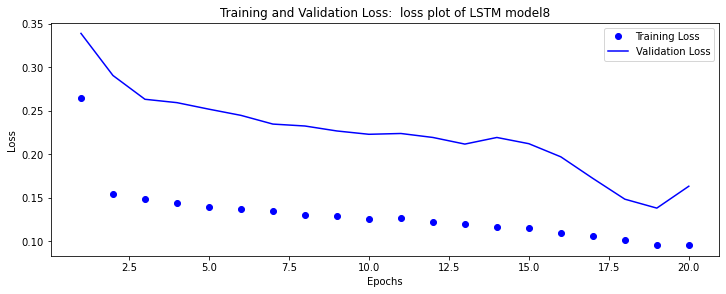

In [17]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(32))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")

Epoch 1/30
13/13 [==============================] - 7s 345ms/step - loss: 0.6235 - val_loss: 0.1330
Epoch 2/30
13/13 [==============================] - 3s 214ms/step - loss: 0.1518 - val_loss: 0.2315
Epoch 3/30
13/13 [==============================] - 3s 222ms/step - loss: 0.1563 - val_loss: 0.2419
Epoch 4/30
13/13 [==============================] - 3s 225ms/step - loss: 0.1573 - val_loss: 0.2336
Epoch 5/30
13/13 [==============================] - 3s 215ms/step - loss: 0.1536 - val_loss: 0.2231
Epoch 6/30
13/13 [==============================] - 3s 219ms/step - loss: 0.1485 - val_loss: 0.2137
Epoch 7/30
13/13 [==============================] - 3s 218ms/step - loss: 0.1435 - val_loss: 0.2060
Epoch 8/30
13/13 [==============================] - 3s 229ms/step - loss: 0.1391 - val_loss: 0.1997
Epoch 9/30
13/13 [==============================] - 3s 227ms/step - loss: 0.1354 - val_loss: 0.1945
Epoch 10/30
13/13 [==============================] - 3s 273ms/step - loss: 0.1321 - val_loss: 0.1902

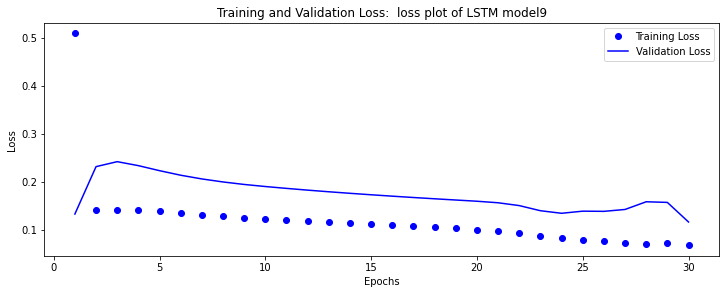

In [18]:
LSTM_model9 = models.Sequential()
LSTM_model9.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model9.add(layers.LSTM(16))


LSTM_model9.add(layers.Dense(1))

LSTM_model9.compile(optimizer=RMSprop(), loss='mse')
LSTM_model9_history = LSTM_model9.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model9_history, "loss plot of LSTM model9")

Epoch 1/20
13/13 [==============================] - 7s 293ms/step - loss: 0.4615 - val_loss: 0.1436
Epoch 2/20
13/13 [==============================] - 4s 288ms/step - loss: 0.1843 - val_loss: 0.2021
Epoch 3/20
13/13 [==============================] - 3s 254ms/step - loss: 0.1610 - val_loss: 0.2098
Epoch 4/20
13/13 [==============================] - 3s 250ms/step - loss: 0.1515 - val_loss: 0.2054
Epoch 5/20
13/13 [==============================] - 3s 249ms/step - loss: 0.1454 - val_loss: 0.1959
Epoch 6/20
13/13 [==============================] - 4s 303ms/step - loss: 0.1400 - val_loss: 0.1866
Epoch 7/20
13/13 [==============================] - 3s 253ms/step - loss: 0.1354 - val_loss: 0.1805
Epoch 8/20
13/13 [==============================] - 3s 249ms/step - loss: 0.1346 - val_loss: 0.1743
Epoch 9/20
13/13 [==============================] - 3s 258ms/step - loss: 0.1316 - val_loss: 0.1692
Epoch 10/20
13/13 [==============================] - 4s 299ms/step - loss: 0.1286 - val_loss: 0.1645

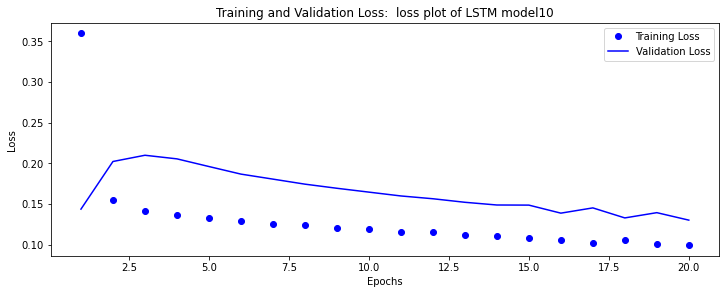

In [19]:
LSTM_model10 = models.Sequential()
LSTM_model10.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model10.add(layers.LSTM(16))


LSTM_model10.add(layers.Dense(1))

LSTM_model10.compile(optimizer=RMSprop(), loss='mse')
LSTM_model10_history = LSTM_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model10_history, "loss plot of LSTM model10")

Epoch 1/50
13/13 [==============================] - 8s 362ms/step - loss: 0.3494 - val_loss: 0.1387
Epoch 2/50
13/13 [==============================] - 3s 232ms/step - loss: 0.2833 - val_loss: 0.1239
Epoch 3/50
13/13 [==============================] - 3s 240ms/step - loss: 0.2507 - val_loss: 0.1177
Epoch 4/50
13/13 [==============================] - 3s 236ms/step - loss: 0.2277 - val_loss: 0.1182
Epoch 5/50
13/13 [==============================] - 3s 237ms/step - loss: 0.2059 - val_loss: 0.1247
Epoch 6/50
13/13 [==============================] - 3s 250ms/step - loss: 0.1935 - val_loss: 0.1360
Epoch 7/50
13/13 [==============================] - 3s 240ms/step - loss: 0.1810 - val_loss: 0.1510
Epoch 8/50
13/13 [==============================] - 3s 236ms/step - loss: 0.1729 - val_loss: 0.1673
Epoch 9/50
13/13 [==============================] - 3s 239ms/step - loss: 0.1665 - val_loss: 0.1843
Epoch 10/50
13/13 [==============================] - 3s 228ms/step - loss: 0.1615 - val_loss: 0.2000

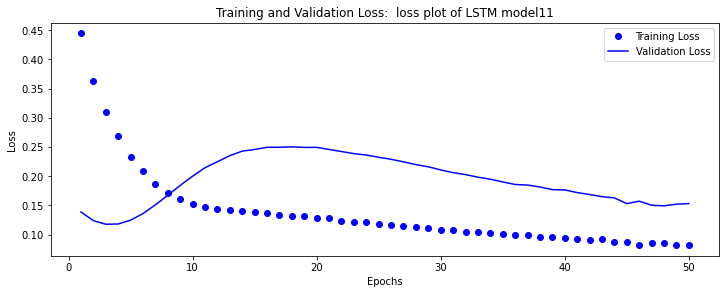

In [20]:
LSTM_model11 = models.Sequential()
LSTM_model11.add(layers.LSTM(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model11.add(layers.LSTM(5))


LSTM_model11.add(layers.Dense(1))

LSTM_model11.compile(optimizer=RMSprop(), loss='mse')
LSTM_model11_history = LSTM_model11.fit(train_dataset, epochs=50, validation_data=val_dataset)

plot_simple_loss(LSTM_model11_history, "loss plot of LSTM model11")

Epoch 1/20
13/13 [==============================] - 14s 524ms/step - loss: 0.3975 - val_loss: 1.2321
Epoch 2/20
13/13 [==============================] - 7s 533ms/step - loss: 0.2891 - val_loss: 0.7799
Epoch 3/20
13/13 [==============================] - 8s 548ms/step - loss: 0.2158 - val_loss: 0.6820
Epoch 4/20
13/13 [==============================] - 8s 593ms/step - loss: 0.2059 - val_loss: 0.6081
Epoch 5/20
13/13 [==============================] - 6s 460ms/step - loss: 0.1945 - val_loss: 0.5505
Epoch 6/20
13/13 [==============================] - 6s 493ms/step - loss: 0.1846 - val_loss: 0.4842
Epoch 7/20
13/13 [==============================] - 7s 576ms/step - loss: 0.1773 - val_loss: 0.4344
Epoch 8/20
13/13 [==============================] - 7s 510ms/step - loss: 0.1680 - val_loss: 0.3937
Epoch 9/20
13/13 [==============================] - 6s 447ms/step - loss: 0.1629 - val_loss: 0.3419
Epoch 10/20
13/13 [==============================] - 7s 532ms/step - loss: 0.1557 - val_loss: 0.322

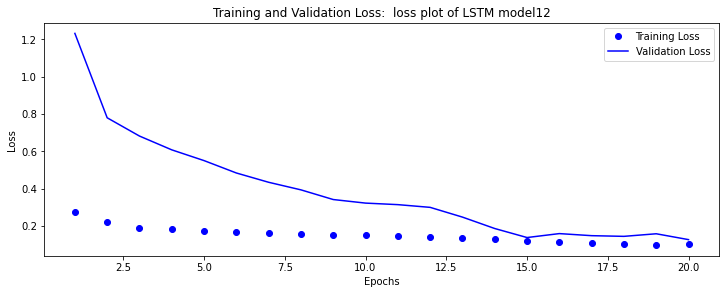

In [21]:
LSTM_model12 = models.Sequential()
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model12.add(layers.LSTM(50))


LSTM_model12.add(layers.Dense(1))

LSTM_model12.compile(optimizer=RMSprop(), loss='mse')
LSTM_model12_history = LSTM_model12.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model12_history, "loss plot of LSTM model12")

Epoch 1/20
13/13 [==============================] - 18s 749ms/step - loss: 0.3979 - val_loss: 1.5738
Epoch 2/20
13/13 [==============================] - 9s 670ms/step - loss: 0.3337 - val_loss: 0.8777
Epoch 3/20
13/13 [==============================] - 8s 594ms/step - loss: 0.2444 - val_loss: 0.8404
Epoch 4/20
13/13 [==============================] - 8s 635ms/step - loss: 0.2222 - val_loss: 0.8069
Epoch 5/20
13/13 [==============================] - 9s 697ms/step - loss: 0.2090 - val_loss: 0.7659
Epoch 6/20
13/13 [==============================] - 8s 605ms/step - loss: 0.2006 - val_loss: 0.7000
Epoch 7/20
13/13 [==============================] - 11s 883ms/step - loss: 0.1913 - val_loss: 0.6684
Epoch 8/20
13/13 [==============================] - 9s 686ms/step - loss: 0.1867 - val_loss: 0.5903
Epoch 9/20
13/13 [==============================] - 9s 675ms/step - loss: 0.1764 - val_loss: 0.5908
Epoch 10/20
13/13 [==============================] - 8s 648ms/step - loss: 0.1726 - val_loss: 0.55

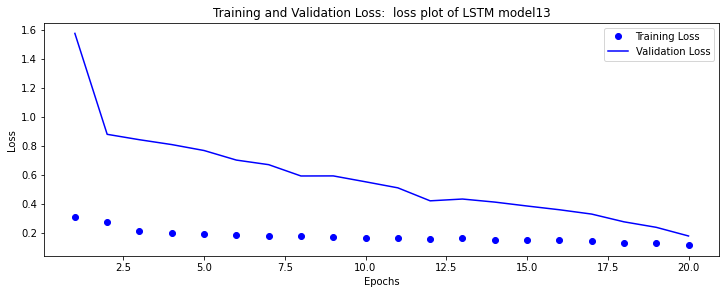

In [22]:
LSTM_model13 = models.Sequential()
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50))


LSTM_model13.add(layers.Dense(1))

LSTM_model13.compile(optimizer=RMSprop(), loss='mse')
LSTM_model13_history = LSTM_model13.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model13_history, "loss plot of LSTM model13")

Epoch 1/20
13/13 [==============================] - 11s 496ms/step - loss: 0.3101 - val_loss: 0.4451
Epoch 2/20
13/13 [==============================] - 5s 407ms/step - loss: 0.1876 - val_loss: 0.3451
Epoch 3/20
13/13 [==============================] - 5s 404ms/step - loss: 0.1649 - val_loss: 0.2959
Epoch 4/20
13/13 [==============================] - 4s 288ms/step - loss: 0.1595 - val_loss: 0.2625
Epoch 5/20
13/13 [==============================] - 4s 304ms/step - loss: 0.1539 - val_loss: 0.2401
Epoch 6/20
13/13 [==============================] - 4s 348ms/step - loss: 0.1489 - val_loss: 0.2238
Epoch 7/20
13/13 [==============================] - 5s 347ms/step - loss: 0.1445 - val_loss: 0.2103
Epoch 8/20
13/13 [==============================] - 4s 308ms/step - loss: 0.1407 - val_loss: 0.1980
Epoch 9/20
13/13 [==============================] - 7s 521ms/step - loss: 0.1371 - val_loss: 0.1858
Epoch 10/20
13/13 [==============================] - 4s 305ms/step - loss: 0.1335 - val_loss: 0.172

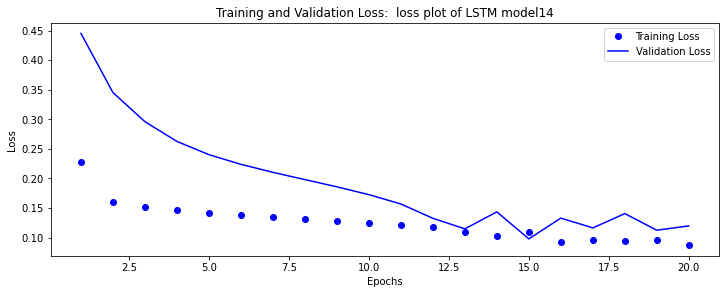

In [23]:
LSTM_model14 = models.Sequential()
LSTM_model14.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model14.add(layers.LSTM(32))


LSTM_model14.add(layers.Dense(1))

LSTM_model14.compile(optimizer=RMSprop(), loss='mse')
LSTM_model14_history = LSTM_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model14_history, "loss plot of LSTM model14")

Epoch 1/40
13/13 [==============================] - 7s 320ms/step - loss: 0.6136 - val_loss: 0.1550
Epoch 2/40
13/13 [==============================] - 3s 238ms/step - loss: 0.2788 - val_loss: 0.1352
Epoch 3/40
13/13 [==============================] - 2s 190ms/step - loss: 0.1710 - val_loss: 0.2029
Epoch 4/40
13/13 [==============================] - 3s 204ms/step - loss: 0.1529 - val_loss: 0.2304
Epoch 5/40
13/13 [==============================] - 3s 237ms/step - loss: 0.1511 - val_loss: 0.2311
Epoch 6/40
13/13 [==============================] - 3s 204ms/step - loss: 0.1486 - val_loss: 0.2258
Epoch 7/40
13/13 [==============================] - 2s 192ms/step - loss: 0.1457 - val_loss: 0.2192
Epoch 8/40
13/13 [==============================] - 3s 224ms/step - loss: 0.1428 - val_loss: 0.2125
Epoch 9/40
13/13 [==============================] - 2s 188ms/step - loss: 0.1404 - val_loss: 0.2060
Epoch 10/40
13/13 [==============================] - 3s 197ms/step - loss: 0.1383 - val_loss: 0.1996

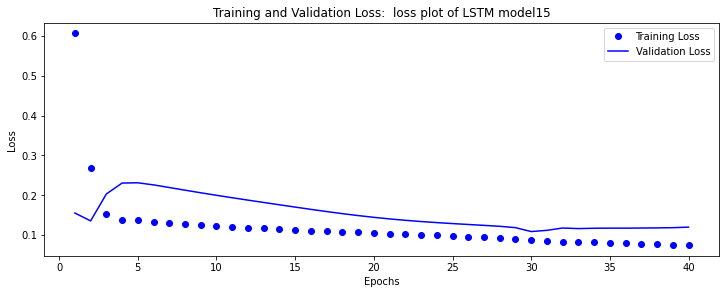

In [24]:
LSTM_model15 = models.Sequential()
LSTM_model15.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model15.add(layers.LSTM(16))


LSTM_model15.add(layers.Dense(1))

LSTM_model15.compile(optimizer=RMSprop(), loss='mse')
LSTM_model15_history = LSTM_model15.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(LSTM_model15_history, "loss plot of LSTM model15")

Epoch 1/20
13/13 [==============================] - 9s 434ms/step - loss: 0.3309 - val_loss: 0.7719
Epoch 2/20
13/13 [==============================] - 5s 365ms/step - loss: 0.2152 - val_loss: 0.5821
Epoch 3/20
13/13 [==============================] - 5s 371ms/step - loss: 0.1744 - val_loss: 0.5065
Epoch 4/20
13/13 [==============================] - 4s 326ms/step - loss: 0.1661 - val_loss: 0.4308
Epoch 5/20
13/13 [==============================] - 4s 321ms/step - loss: 0.1591 - val_loss: 0.3694
Epoch 6/20
13/13 [==============================] - 5s 396ms/step - loss: 0.1522 - val_loss: 0.3232
Epoch 7/20
13/13 [==============================] - 6s 435ms/step - loss: 0.1459 - val_loss: 0.2875
Epoch 8/20
13/13 [==============================] - 6s 436ms/step - loss: 0.1401 - val_loss: 0.2607
Epoch 9/20
13/13 [==============================] - 4s 331ms/step - loss: 0.1339 - val_loss: 0.2365
Epoch 10/20
13/13 [==============================] - 5s 388ms/step - loss: 0.1253 - val_loss: 0.1864

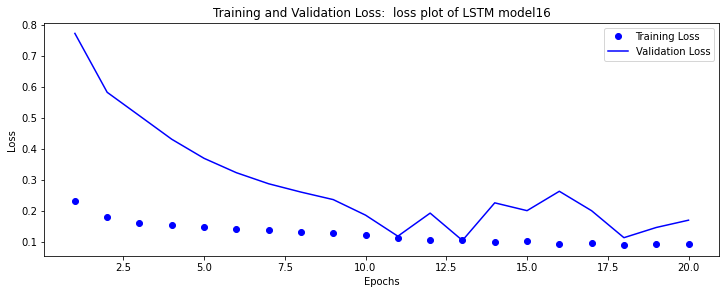

In [25]:
LSTM_model16 = models.Sequential()
LSTM_model16.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model16.add(layers.LSTM(64))


LSTM_model16.add(layers.Dense(1))

LSTM_model16.compile(optimizer=RMSprop(), loss='mse')
LSTM_model16_history = LSTM_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model16_history, "loss plot of LSTM model16")

Epoch 1/30
13/13 [==============================] - 12s 535ms/step - loss: 0.4169 - val_loss: 1.0256
Epoch 2/30
13/13 [==============================] - 5s 382ms/step - loss: 0.2715 - val_loss: 0.6155
Epoch 3/30
13/13 [==============================] - 5s 382ms/step - loss: 0.2106 - val_loss: 0.5895
Epoch 4/30
13/13 [==============================] - 6s 466ms/step - loss: 0.2013 - val_loss: 0.5568
Epoch 5/30
13/13 [==============================] - 6s 444ms/step - loss: 0.1942 - val_loss: 0.5223
Epoch 6/30
13/13 [==============================] - 5s 367ms/step - loss: 0.1881 - val_loss: 0.4884
Epoch 7/30
13/13 [==============================] - 5s 404ms/step - loss: 0.1823 - val_loss: 0.4554
Epoch 8/30
13/13 [==============================] - 5s 384ms/step - loss: 0.1766 - val_loss: 0.4228
Epoch 9/30
13/13 [==============================] - 5s 393ms/step - loss: 0.1705 - val_loss: 0.3900
Epoch 10/30
13/13 [==============================] - 5s 393ms/step - loss: 0.1640 - val_loss: 0.355

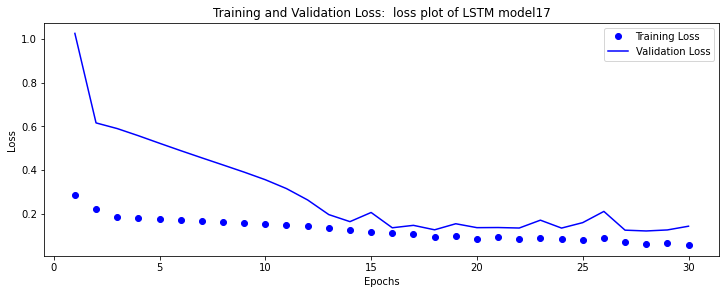

In [26]:
LSTM_model17 = models.Sequential()
LSTM_model17.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32))


LSTM_model17.add(layers.Dense(1))

LSTM_model17.compile(optimizer=RMSprop(), loss='mse')
LSTM_model17_history = LSTM_model17.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model17_history, "loss plot of LSTM model17")

Epoch 1/30
13/13 [==============================] - 12s 504ms/step - loss: 0.4263 - val_loss: 0.8622
Epoch 2/30
13/13 [==============================] - 4s 313ms/step - loss: 0.2423 - val_loss: 0.5977
Epoch 3/30
13/13 [==============================] - 4s 320ms/step - loss: 0.2029 - val_loss: 0.5069
Epoch 4/30
13/13 [==============================] - 4s 312ms/step - loss: 0.1884 - val_loss: 0.4446
Epoch 5/30
13/13 [==============================] - 4s 323ms/step - loss: 0.1789 - val_loss: 0.3979
Epoch 6/30
13/13 [==============================] - 5s 379ms/step - loss: 0.1713 - val_loss: 0.3602
Epoch 7/30
13/13 [==============================] - 5s 359ms/step - loss: 0.1646 - val_loss: 0.3293
Epoch 8/30
13/13 [==============================] - 4s 315ms/step - loss: 0.1581 - val_loss: 0.3052
Epoch 9/30
13/13 [==============================] - 4s 299ms/step - loss: 0.1513 - val_loss: 0.2865
Epoch 10/30
13/13 [==============================] - 4s 316ms/step - loss: 0.1434 - val_loss: 0.256

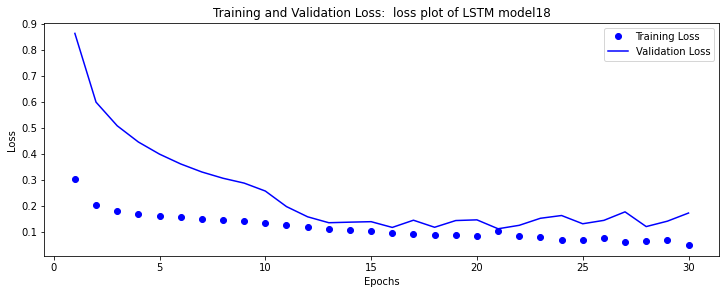

In [27]:
LSTM_model18 = models.Sequential()
LSTM_model18.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model18.add(layers.LSTM(32, return_sequences=True))
LSTM_model18.add(layers.LSTM(32))


LSTM_model18.add(layers.Dense(1))

LSTM_model18.compile(optimizer=RMSprop(), loss='mse')
LSTM_model18_history = LSTM_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model18_history, "loss plot of LSTM model18")

In [28]:
histories = [LSTM_model1_history, LSTM_model2_history, LSTM_model3_history, LSTM_model4_history, LSTM_model5_history, LSTM_model6_history, LSTM_model7_history, LSTM_model8_history, LSTM_model9_history, LSTM_model10_history, LSTM_model11_history, LSTM_model12_history, LSTM_model13_history, LSTM_model14_history, LSTM_model15_history, LSTM_model16_history, LSTM_model17_history, LSTM_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 0.10830936580896378, epoch: 11
Model 2: min val loss: 0.10163362324237823, epoch: 11
Model 3: min val loss: 0.10101151466369629, epoch: 15
Model 4: min val loss: 0.09809880703687668, epoch: 12
Model 5: min val loss: 0.1148955449461937, epoch: 28
Model 6: min val loss: 0.11672563850879669, epoch: 17
Model 7: min val loss: 0.08920034766197205, epoch: 27
Model 8: min val loss: 0.13827282190322876, epoch: 19
Model 9: min val loss: 0.11640504002571106, epoch: 30
Model 10: min val loss: 0.1300506442785263, epoch: 20
Model 11: min val loss: 0.11774871498346329, epoch: 3
Model 12: min val loss: 0.12718802690505981, epoch: 20
Model 13: min val loss: 0.17645370960235596, epoch: 20
Model 14: min val loss: 0.09776251018047333, epoch: 15
Model 15: min val loss: 0.10846664756536484, epoch: 30
Model 16: min val loss: 0.10491017997264862, epoch: 13
Model 17: min val loss: 0.12040207535028458, epoch: 28
Model 18: min val loss: 0.11105400323867798, epoch: 21
